In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import glob
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from itertools import combinations

In [2]:
forecast_demand_file_path = '../data/forecastdemand_nsw.csv'
actual_demand_file_path = '../data/totaldemand_nsw.csv'
temperature_file_path = '../data/temperature_nsw.csv'
forecast_demand = pd.read_csv(forecast_demand_file_path)
actual_demand = pd.read_csv(actual_demand_file_path)
temperature = pd.read_csv(temperature_file_path)

Exports_file_path = '../data/Exports - quarterly 2010-2023.csv'
GDP_file_path = '../data/GDP - quarterly 2010-2023.csv'
Interest_file_path = '../data/Interest rate - daily 2011-2023.csv'
SolarInstall_file_path = '../data/Solar installation number - monthly 2007-2023.csv'
SolarOutput_file_path = '../data/Solar outputs - monthly 2015-2023.csv'
Unemployment_file_path = '../data/Unemployment rate - monthly 2010-2023.csv'
Wholesale_file_path = '../data/Wholesale electricity price - half hourly 2014-2023.csv'
cpi_file_path = '../data/inflation-data.xls'
comm_file_path = '../data/Commodity prices index - monthly 2010-2023.csv'
rainfall_file_path = '../data/Rainfall - daily 2010-2023.csv'
weather_file_path = '../data/Weather - daily 2022-2023.csv'

cpi = pd.read_excel(cpi_file_path)
Exports = pd.read_csv(Exports_file_path)
GDP = pd.read_csv(GDP_file_path)
Interest = pd.read_csv(Interest_file_path)
SolarInstall = pd.read_csv(SolarInstall_file_path)
SolarOutput = pd.read_csv(SolarOutput_file_path)
Unemployment = pd.read_csv(Unemployment_file_path)
Wholesale = pd.read_csv(Wholesale_file_path)
Comm = pd.read_csv(comm_file_path)
Rainfall = pd.read_csv(rainfall_file_path)
Weather = pd.read_csv(weather_file_path)

In [3]:
forecast_demand.head()

,DATETIME,REGIONID,FORECASTDEMAND,PREDISPATCHSEQNO,PERIODID,LASTCHANGED
0,2010-01-01 00:00:00,NSW1,7832.04,2009123018,71,2009-12-30 12:31:49
1,2010-01-01 00:00:00,NSW1,7832.04,2009123019,70,2009-12-30 13:01:43
2,2010-01-01 00:00:00,NSW1,7832.03,2009123020,69,2009-12-30 13:31:36
3,2010-01-01 00:00:00,NSW1,7832.03,2009123021,68,2009-12-30 14:01:44
4,2010-01-01 00:00:00,NSW1,7830.96,2009123022,67,2009-12-30 14:31:35


In [4]:
actual_demand.head()
actual_demand.tail()

,DATETIME,REGIONID,TOTALDEMAND
1323393,2022-07-31 23:40:00,NSW1,8180.34
1323394,2022-07-31 23:45:00,NSW1,8237.50
1323395,2022-07-31 23:50:00,NSW1,8109.83
1323396,2022-07-31 23:55:00,NSW1,8044.52
1323397,2022-08-01 00:00:00,NSW1,8027.28


In [5]:
temperature.head()
temperature.tail()
temperature.loc[temperature['TEMPERATURE'] <= -5, 'TEMPERATURE'] = np.nan
temperature.min()

DATETIME       2010-01-01 00:00:00
LOCATION                     94766
TEMPERATURE                   -1.3
dtype: object

In [6]:
path = '../data/nswdemand2022onwards'
all_files = glob.glob(os.path.join(path, "*.csv"))

total_demand_2022onwards = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

In [7]:
total_demand_2022onwards.head()

,REGION,SETTLEMENTDATE,TOTALDEMAND,RRP,PERIODTYPE
0,NSW1,2022/01/01 00:05:00,7206.03,124.86,TRADE
1,NSW1,2022/01/01 00:10:00,7174.26,126.02,TRADE
2,NSW1,2022/01/01 00:15:00,7135.00,124.93,TRADE
3,NSW1,2022/01/01 00:20:00,7065.84,113.54,TRADE
4,NSW1,2022/01/01 00:25:00,6995.08,123.12,TRADE


In [8]:
df = pd.DataFrame({'Date Time': actual_demand['DATETIME'], 'Total Demand': actual_demand['TOTALDEMAND']})
df.head()

,Date Time,Total Demand
0,2010-01-01 00:00:00,7997.41
1,2010-01-01 00:05:00,7946.51
2,2010-01-01 00:10:00,7921.55
3,2010-01-01 00:15:00,7837.84
4,2010-01-01 00:20:00,7781.11


In [9]:
df = pd.merge(df,temperature,left_on=['Date Time'], right_on=['DATETIME'], how = 'left')
df=df.drop(columns=['DATETIME', 'LOCATION'])
df.head(15)

,Date Time,Total Demand,TEMPERATURE
0,2010-01-01 00:00:00,7997.41,23.1
1,2010-01-01 00:05:00,7946.51,NaN
2,2010-01-01 00:10:00,7921.55,NaN
3,2010-01-01 00:15:00,7837.84,NaN
4,2010-01-01 00:20:00,7781.11,NaN
5,2010-01-01 00:25:00,7685.53,NaN
6,2010-01-01 00:30:00,7683.34,22.9
7,2010-01-01 00:35:00,7624.60,NaN
8,2010-01-01 00:40:00,7606.74,NaN
9,2010-01-01 00:45:00,7555.47,NaN


In [10]:
df['TEMPERATURE'] = df['TEMPERATURE'].interpolate(method='linear')

In [11]:
df.head(15)

,Date Time,Total Demand,TEMPERATURE
0,2010-01-01 00:00:00,7997.41,23.100000
1,2010-01-01 00:05:00,7946.51,23.066667
2,2010-01-01 00:10:00,7921.55,23.033333
3,2010-01-01 00:15:00,7837.84,23.000000
4,2010-01-01 00:20:00,7781.11,22.966667
5,2010-01-01 00:25:00,7685.53,22.933333
6,2010-01-01 00:30:00,7683.34,22.900000
7,2010-01-01 00:35:00,7624.60,22.850000
8,2010-01-01 00:40:00,7606.74,22.800000
9,2010-01-01 00:45:00,7555.47,22.750000


In [12]:
df['Date Time'] = pd.to_datetime(df['Date Time'])

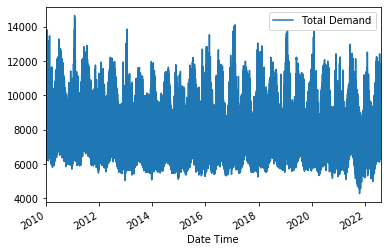

In [13]:
df.plot(x='Date Time', y = 'Total Demand')

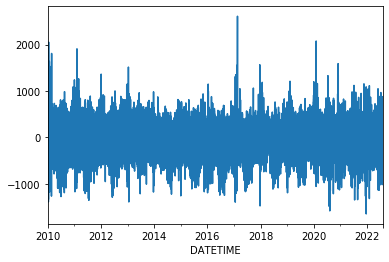

In [14]:
forecast_demand['DATETIME'] = pd.to_datetime(forecast_demand['DATETIME'])
actual_demand['DATETIME'] = pd.to_datetime(actual_demand['DATETIME'])
(forecast_demand.set_index('DATETIME').resample('1H').mean()['FORECASTDEMAND'] - actual_demand.set_index('DATETIME').resample('1H').mean()['TOTALDEMAND']).plot()

In [15]:
forecast_demand['DATETIME'] = pd.to_datetime(forecast_demand['DATETIME'])
actual_demand['DATETIME'] = pd.to_datetime(actual_demand['DATETIME'])
fore = forecast_demand.set_index('DATETIME').resample('1H').mean()[['FORECASTDEMAND']]

In [16]:
actu = actual_demand.set_index('DATETIME').resample('1H').mean()[['TOTALDEMAND']]

In [17]:
merged_df = fore.join(actu).dropna()

In [18]:
merged_df['DIFF'] = merged_df.eval('TOTALDEMAND - FORECASTDEMAND')

In [19]:
mse = mean_squared_error(merged_df['FORECASTDEMAND'], merged_df['TOTALDEMAND'])
r2 = r2_score(merged_df['FORECASTDEMAND'], merged_df['TOTALDEMAND'])

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 82514.66202466807
R-squared: 0.9519046393461148


In [20]:
merged_df

,FORECASTDEMAND,TOTALDEMAND,DIFF
DATETIME,,,
2010-01-01 00:00:00,7753.063237,7707.110833,-45.952404
2010-01-01 01:00:00,7258.107972,7014.171667,-243.936305
2010-01-01 02:00:00,6619.177007,6491.061667,-128.115340
2010-01-01 03:00:00,6232.568278,6256.344167,23.775889
2010-01-01 04:00:00,6082.359439,6225.776667,143.417227
...,...,...,...
2022-07-31 20:00:00,10225.684016,10081.598333,-144.085682
2022-07-31 21:00:00,9737.377099,9399.320000,-338.057099
2022-07-31 22:00:00,9139.791481,8769.945833,-369.845648


In [21]:
lag_value =-3
merged_df['Demand_Previous'] = merged_df['TOTALDEMAND'].shift(periods=(-24))
merged_df['Demand_Lagged'] = merged_df['TOTALDEMAND'].shift(periods=(lag_value))
merged_df['Demand_Rolling'] = merged_df['Demand_Lagged'].rolling(window=720).mean()

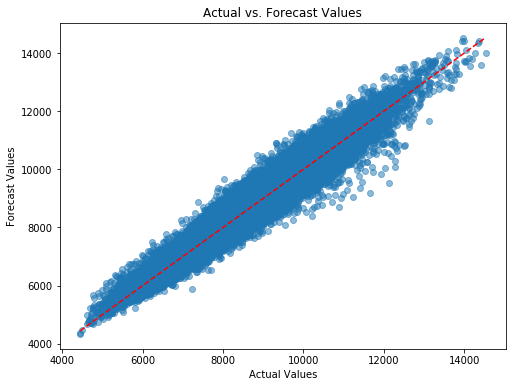

In [22]:
plt.figure(figsize=(8, 6))
plt.scatter(merged_df['FORECASTDEMAND'], merged_df['TOTALDEMAND'], alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Forecast Values")
plt.title("Actual vs. Forecast Values")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(merged_df['FORECASTDEMAND']), max(merged_df['FORECASTDEMAND'])], [min(merged_df['FORECASTDEMAND']), max(merged_df['FORECASTDEMAND'])], color='red', linestyle='--')

plt.show()

In [23]:
act_demand = actual_demand.set_index('DATETIME').resample('1H').mean()

In [24]:
merged_df['HourOfDay'] = merged_df.index.hour
merged_df['DayOfWeek'] = merged_df.index.dayofweek
merged_df['DayOfYear'] = merged_df.index.dayofyear
merged_df['IsWeekend'] = np.where((merged_df['DayOfWeek'] == 5) | (merged_df['DayOfWeek'] == 6), 1, 0)

In [25]:
merged_df

,FORECASTDEMAND,TOTALDEMAND,DIFF,Demand_Previous,Demand_Lagged,Demand_Rolling,HourOfDay,DayOfWeek,DayOfYear,IsWeekend
DATETIME,,,,,,,,,,
2010-01-01 00:00:00,7753.063237,7707.110833,-45.952404,7265.698333,6256.344167,NaN,0,4,1,0
2010-01-01 01:00:00,7258.107972,7014.171667,-243.936305,6684.050833,6225.776667,NaN,1,4,1,0
2010-01-01 02:00:00,6619.177007,6491.061667,-128.115340,6303.523333,6286.084167,NaN,2,4,1,0
2010-01-01 03:00:00,6232.568278,6256.344167,23.775889,6163.745000,6583.337500,NaN,3,4,1,0
2010-01-01 04:00:00,6082.359439,6225.776667,143.417227,6239.421667,7057.600833,NaN,4,4,1,0
...,...,...,...,...,...,...,...,...,...,...
2022-07-31 20:00:00,10225.684016,10081.598333,-144.085682,NaN,8285.235833,8880.401693,20,6,212,1
2022-07-31 21:00:00,9737.377099,9399.320000,-338.057099,NaN,8027.280000,8879.589321,21,6,212,1
2022-07-31 22:00:00,9139.791481,8769.945833,-369.845648,NaN,NaN,NaN,22,6,212,1


In [26]:
temperature['DATETIME'] = pd.to_datetime(temperature['DATETIME'])
temp = temperature.set_index('DATETIME').resample('1H').mean()

# Apply the lag to the 'TOTALDEMAND' column
temp['TEMPERATURE_lagged'] = temp['TEMPERATURE'].shift(periods=lag_value)

In [27]:
temp.head(20)

,LOCATION,TEMPERATURE,TEMPERATURE_lagged
DATETIME,,,
2010-01-01 00:00:00,94766.0,22.95,22.30
2010-01-01 01:00:00,94766.0,22.55,22.15
2010-01-01 02:00:00,94766.0,22.45,22.25
2010-01-01 03:00:00,94766.0,22.30,22.85
2010-01-01 04:00:00,94766.0,22.15,23.55
2010-01-01 05:00:00,94766.0,22.25,24.55
2010-01-01 06:00:00,94766.0,22.85,24.95
2010-01-01 07:00:00,94766.0,23.55,24.85
2010-01-01 08:00:00,94766.0,24.55,25.50


In [28]:
data = merged_df.merge(temp, left_index=True, right_index=True, how='inner')

In [29]:
data = data.drop(['LOCATION','TEMPERATURE', 'FORECASTDEMAND', 'DIFF'], axis=1)

In [30]:
data = data.dropna()

In [31]:
data

,TOTALDEMAND,Demand_Previous,Demand_Lagged,Demand_Rolling,HourOfDay,DayOfWeek,DayOfYear,IsWeekend,TEMPERATURE_lagged
DATETIME,,,,,,,,,
2010-01-30 23:00:00,7863.851667,7708.889167,6628.467500,8970.507567,23,5,30,1,21.466667
2010-01-31 00:00:00,7417.040833,7399.175833,6536.074167,8970.896081,0,6,31,1,21.500000
2010-01-31 01:00:00,6925.912500,6946.539167,6594.960000,8971.408836,1,6,31,1,20.900000
2010-01-31 02:00:00,6628.467500,6686.038333,6706.481667,8971.992721,2,6,31,1,20.933333
2010-01-31 03:00:00,6536.074167,6683.740833,7121.767500,8972.740541,3,6,31,1,22.050000
...,...,...,...,...,...,...,...,...,...
2022-07-30 20:00:00,10379.721667,10081.598333,9120.602500,8912.385219,20,5,211,1,5.000000
2022-07-30 21:00:00,10021.330833,9399.320000,8617.879167,8912.530616,21,5,211,1,4.650000
2022-07-30 22:00:00,9610.437500,8769.945833,8107.912500,8912.530472,22,5,211,1,4.400000


In [32]:
target_column = 'TOTALDEMAND'
feature_columns = [col for col in data.columns if col != target_column]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data[feature_columns], data[target_column], test_size=0.2, random_state=42)

# Create an instance of the LinearRegression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Optionally, you can inspect the model coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

print("Coefficients:", coefficients)
print("Intercept:", intercept)

Mean Squared Error: 284951.87432655005
R-squared: 0.8326284001702478
Coefficients: [ 6.42099867e-01  2.11940216e-01  1.66626418e-01  2.73364116e+01
  6.10596103e+01  2.47875200e-02 -5.42314530e+02  4.15183146e+00]
Intercept: -586.3084689107736


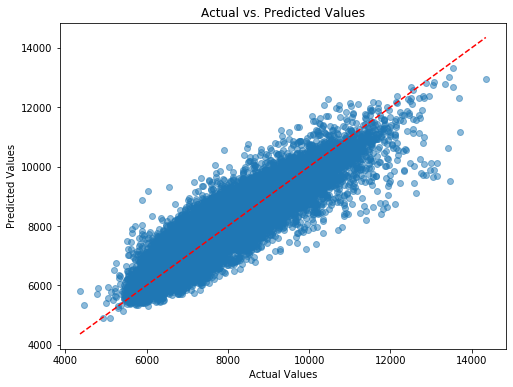

In [33]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

plt.show()

In [34]:
# Assuming you have a DataFrame named 'data' with a 'Date' index and columns
# 'HourOfDay', 'DayOfWeek', 'DayOfYear', 'TEMPERATURE_lagged', and 'TOTALDEMAND'

# Define target and feature columns
target_column = 'TOTALDEMAND'
feature_columns = ['HourOfDay', 'DayOfWeek', 'DayOfYear', 'IsWeekend', 'TEMPERATURE_lagged','Demand_Previous', 'Demand_Lagged', 'Demand_Rolling']

# Set the date threshold for training data (end of November 2020)
training_end_date = '2020-11-30'

# Split the data into training and testing sets
train_data = data.loc[data.index <= training_end_date]
test_data = data.loc[data.index > training_end_date]

# Define training and testing features and target
X_train = train_data[feature_columns]
y_train = train_data[target_column]

X_test = test_data[feature_columns]
y_test = test_data[target_column]

# Create an XGBoost Regressor model
xgb_model = XGBRegressor(n_estimators=50, random_state=42)

# Train the model on the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb_model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 145694.37459780092
R-squared: 0.9075259214816697


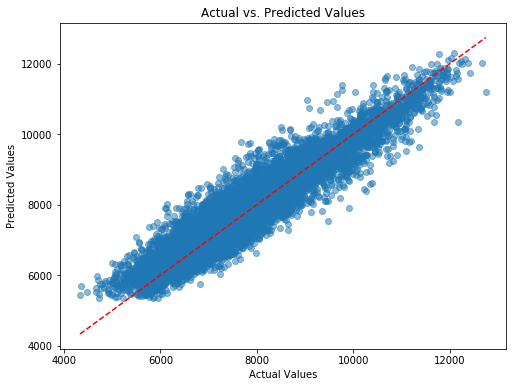

In [35]:
# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

plt.show()

In [36]:
cpi = cpi[['G1 CONSUMER PRICE INFLATION','Unnamed: 2']][10:]
column_rename_mapping = {
    'G1 CONSUMER PRICE INFLATION': 'DATETIME',
    'Unnamed: 2': 'CPI',
}
cpi = cpi.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date = data.index.min()
max_date = data.index.max()
cpi = cpi[(cpi.index >= min_date) & (cpi.index <= max_date)]
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
cpi = cpi.reindex(date_range).fillna(method='ffill')
lag_value = -6
# Apply the lag to the 'TOTALDEMAND' column
cpi['CPI_lagged'] = cpi['CPI'].shift(periods=lag_value)
df = pd.concat([data, cpi], axis=1)
df = df.drop('CPI', axis = 1).dropna()

In [37]:
# Define target and feature columns
target_column = 'TOTALDEMAND'
feature_columns = ['HourOfDay', 'DayOfWeek', 'DayOfYear', 'IsWeekend', 'TEMPERATURE_lagged','CPI_lagged','Demand_Previous','Demand_Lagged','Demand_Rolling']

# Set the date threshold for training data (end of November 2020)
training_end_date = '2020-11-30'

# Split the data into training and testing sets
train_data = df.loc[df.index <= training_end_date]
test_data = df.loc[df.index > training_end_date]

# Define training and testing features and target
X_train = train_data[feature_columns]
y_train = train_data[target_column]

X_test = test_data[feature_columns]
y_test = test_data[target_column]

# Create an XGBoost Regressor model
xgb_model = XGBRegressor(n_estimators=50, random_state=42)

# Train the model on the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb_model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 159126.92010935693
R-squared: 0.8989112481018934


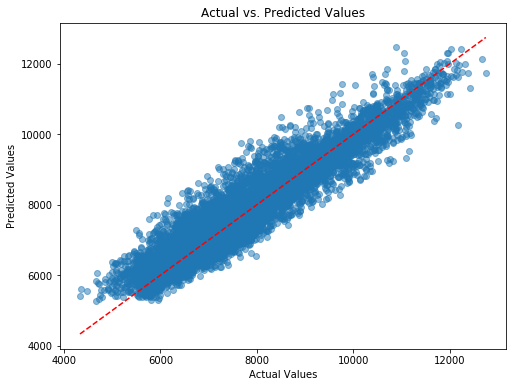

In [38]:
# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

plt.show()

In [39]:
forecast_demand_file_path = '../data/forecastdemand_nsw.csv'
actual_demand_file_path = '../data/totaldemand_nsw.csv'
temperature_file_path = '../data/temperature_nsw.csv'
forecast_demand = pd.read_csv(forecast_demand_file_path)
actual_demand = pd.read_csv(actual_demand_file_path)
temperature = pd.read_csv(temperature_file_path)

In [40]:
Exports

,Date,Exports of goods and services,Year-ended exports growth,Rural exports,Resource exports,Coal exports,Metal ores exports,Other mineral fuels exports,Manufactures exports,Services exports
0,Mar-2010,84752000000,4.7,8795000000,46606600000,8182000000,25160000000,4798000000,8761800000,16876000000
1,Jun-2010,85884000000,8.5,8618000000,47938900000,8398000000,24344000000,5234000000,8656800000,16953000000
2,Sep-2010,84393000000,4.8,9194000000,45248200000,8109000000,22973000000,5336000000,8530400000,17101000000
3,Dec-2010,86157000000,4.9,8977000000,47936700000,8059000000,26113000000,5118000000,8919000000,16833000000
4,Mar-2011,81749000000,-3.5,8976000000,44416200000,6974000000,24236000000,4851000000,8712400000,16362000000
5,Jun-2011,83810000000,-2.4,9471000000,45114100000,7113000000,25253000000,5229000000,8909000000,16804000000
6,Sep-2011,86527000000,2.5,10028000000,47410100000,7667000000,27265000000,4540000000,8966000000,16435000000
7,Dec-2011,88609000000,2.8,10644000000,48867500000,8038000000,28218000000,4609000000,8887900000,16243000000
8,Mar-2012,86408000000,5.7,10175000000,47154000000,7990000000,27388000000,4613000000,9056900000,16079000000
9,Jun-2012,90044000000,7.4,10826000000,49666400000,7971000000,28799000000,4908000000,9185600000,16405000000


In [41]:
column_rename_mapping = {
    'Date': 'DATETIME',
    'Exports of goods and services': 'Exports'
}
Exports = Exports.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date = df.index.min()
max_date = df.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
Exports.index = pd.to_datetime(Exports.index, format='%b-%Y')
Exports = Exports[(Exports.index >= min_date) & (Exports.index <= max_date)]
Exports = Exports.reindex(date_range).fillna(method='ffill')
lag_value = -6
# Apply the lag to the 'TOTALDEMAND' column
Exports['Exports_lagged'] = Exports['Exports'].shift(periods=lag_value)
Exports = Exports[['Exports_lagged']]

In [42]:
df = pd.concat([df, Exports], axis=1).dropna()

In [43]:
GDP

,Date,Real GDP,Year-ended real GDP growth,Real non-farm GDP,Year-ended real non-farm GDP growth,Year-ended real GDP per capita growth,Real GDI,Year-ended real GDI growth,Household consumption
0,Mar-2010,403958000000,2.3,394523000000,2.4,0.6,390594000000,1.7,215064000000
1,Jun-2010,406564000000,2.2,396804000000,2.2,0.6,403110000000,6.5,218204000000
2,Sep-2010,409339000000,2.5,399411000000,2.6,1.1,406641000000,7.5,220375000000
3,Dec-2010,412790000000,2.6,402597000000,2.6,1.2,412294000000,7.3,222798000000
4,Mar-2011,411551000000,1.9,401420000000,1.7,0.5,415225000000,6.3,224122000000
5,Jun-2011,416777000000,2.5,406429000000,2.4,1.1,422693000000,4.9,225631000000
6,Sep-2011,422465000000,3.2,412047000000,3.2,1.7,430200000000,5.8,227063000000
7,Dec-2011,426994000000,3.4,416894000000,3.6,1.8,430683000000,4.5,227953000000
8,Mar-2012,431139000000,4.8,420707000000,4.8,3.0,430152000000,3.6,231170000000
9,Jun-2012,434261000000,4.2,424131000000,4.4,2.4,432301000000,2.3,232159000000


In [44]:
column_rename_mapping = {
    'Date': 'DATETIME',
    'Real GDP': 'GDP'
}
GDP = GDP.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date = df.index.min()
max_date = df.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
GDP.index = pd.to_datetime(GDP.index, format='%b-%Y')
GDP = GDP[(GDP.index >= min_date) & (GDP.index <= max_date)]
GDP = GDP.reindex(date_range).fillna(method='ffill')
lag_value = -6
# Apply the lag to the 'TOTALDEMAND' column
GDP['GDP_lagged'] = GDP['GDP'].shift(periods=lag_value)
GDP = GDP[['GDP_lagged']]

In [45]:
df = pd.concat([df, GDP], axis=1)#.dropna()

In [46]:
Interest

,Date,Cash Rate Target,Interbank Overnight Cash Rate
0,04-Jan-2011,4.75,4.75
1,05-Jan-2011,4.75,4.75
2,06-Jan-2011,4.75,4.75
3,07-Jan-2011,4.75,4.75
4,10-Jan-2011,4.75,4.75
...,...,...,...
3210,11-Sep-2023,4.10,4.07
3211,12-Sep-2023,4.10,4.07
3212,13-Sep-2023,4.10,4.07
3213,14-Sep-2023,4.10,4.07


In [47]:
column_rename_mapping = {
    'Date': 'DATETIME',
    'Cash Rate Target': 'Interest'
}
Interest = Interest.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date = df.index.min()
max_date = df.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
Interest.index = pd.to_datetime(Interest.index)
Interest = Interest[(Interest.index >= min_date) & (Interest.index <= max_date)]
Interest = Interest.reindex(date_range).fillna(method='ffill')
lag_value = -6
# Apply the lag to the 'TOTALDEMAND' column
Interest['Interest_lagged'] = Interest['Interest'].shift(periods=lag_value)
Interest = Interest[['Interest_lagged']]

In [48]:
df = pd.concat([df, Interest], axis=1)

In [49]:
SolarInstall

,'Month','<2.5kW','2.5–4.5','4.5–6.5','6.5–9.5',Total Residential,Cumulative Residential,'9.5–14','14–25','25–50','50–100','100kW–5MW','5MW–30MW','30+ MW',Total Commercial,Cumulative Commercial
0,2007-01,11,15,0,0,26,26,0,0,0,0,0,0,0,0,0
1,2007-02,24,7,5,7,43,69,0,0,0,0,0,0,0,0,0
2,2007-03,31,6,0,7,44,113,0,0,0,0,0,0,0,0,0
3,2007-04,22,10,0,13,45,158,0,0,0,0,0,0,0,0,0
4,2007-05,32,17,5,0,54,212,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,2023-02,215,1252,5533,26882,33882,3389297,32268,6016,3490,2363,3296,0,0,47433,6686508
194,2023-03,253,1382,5106,28598,35339,3424636,33395,7843,3768,2795,3313,0,0,51114,6737622
195,2023-04,194,1149,3921,22079,27343,3451979,27555,5774,3957,2835,300,0,0,40421,6778043
196,2023-05,216,1528,4867,27570,34181,3486160,35558,6664,3666,3340,200,0,75034,124462,6902505


In [50]:
column_rename_mapping = {
    "'Month'": 'DATETIME',
    'Cumulative Residential': 'Residential',
    'Cumulative Commercial': 'Commercial'
}
SolarInstall = SolarInstall.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date = df.index.min()
max_date = df.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
SolarInstall.index = pd.to_datetime(SolarInstall.index)
SolarInstall = SolarInstall[(SolarInstall.index >= min_date) & (SolarInstall.index <= max_date)]
SolarInstall = SolarInstall.reindex(date_range).fillna(method='ffill')
lag_value = -6
# SolarInstall the lag to the 'TOTALDEMAND' column
SolarInstall['Residential_lagged'] = SolarInstall['Residential'].shift(periods=lag_value)
SolarInstall['Commercial_lagged'] = SolarInstall['Commercial'].shift(periods=lag_value)
SolarInstall = SolarInstall[['Residential_lagged','Commercial_lagged']]

In [51]:
df = pd.concat([df, SolarInstall], axis=1)

In [52]:
SolarOutput

,Date,Output NSW
0,2015-04,11308
1,2015-05,11515
2,2015-06,10166
3,2015-07,12928
4,2015-08,15833
...,...,...
95,2023-03,575406
96,2023-04,482746
97,2023-05,476529
98,2023-06,375927


In [53]:
column_rename_mapping = {
    "Date": 'DATETIME',
    'Output NSW': 'SolarOutput'
}
SolarOutput = SolarOutput.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date = df.index.min()
max_date = df.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
SolarOutput.index = pd.to_datetime(SolarOutput.index)
SolarOutput = SolarOutput[(SolarOutput.index >= min_date) & (SolarOutput.index <= max_date)]
SolarOutput = SolarOutput.reindex(date_range).fillna(method='ffill')
lag_value = -6
# SolarInstall the lag to the 'TOTALDEMAND' column
SolarOutput['SolarOutput_lagged'] = SolarOutput['SolarOutput'].shift(periods=lag_value)
SolarOutput = SolarOutput[['SolarOutput_lagged']]

In [54]:
df = pd.concat([df, SolarOutput], axis=1)

In [55]:
Unemployment

,Date,Labour force persons,Labour force participation rate,Employment persons,Year-ended employment growth,Employment to population ratio,Unemployment persons,Unemployment rate
0,Jan-2010,11544872,65.4,10936980,1.3,61.9,607892,5.3
1,Feb-2010,11530715,65.2,10919642,1.1,61.7,611073,5.3
2,Mar-2010,11551709,65.2,10925327,1.4,61.7,626382,5.4
3,Apr-2010,11573384,65.3,10937151,1.3,61.7,636233,5.5
4,May-2010,11542381,65.0,10938850,1.5,61.6,603530,5.2
...,...,...,...,...,...,...,...,...
159,Apr-2023,14476714,66.8,13942522,3.3,64.3,534192,3.7
160,May-2023,14536008,66.9,14016954,3.4,64.5,519053,3.6
161,Jun-2023,14550335,66.9,14044439,3.0,64.5,505897,3.5
162,Jul-2023,14586200,66.9,14043040,2.8,64.4,543160,3.7


In [56]:
column_rename_mapping = {
    "Date": 'DATETIME',
    'Unemployment rate': 'Unemployment'
}
Unemployment = Unemployment.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date = df.index.min()
max_date = df.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
Unemployment.index = pd.to_datetime(Unemployment.index, format='%b-%Y')
Unemployment = Unemployment[(Unemployment.index >= min_date) & (Unemployment.index <= max_date)]
Unemployment = Unemployment.reindex(date_range).fillna(method='ffill')
lag_value = -6
# SolarInstall the lag to the 'TOTALDEMAND' column
Unemployment['Unemployment_lagged'] = Unemployment['Unemployment'].shift(periods=lag_value)
Unemployment = Unemployment[['Unemployment_lagged']]

In [57]:
df = pd.concat([df, Unemployment], axis=1)

In [58]:
Wholesale

,REGION,SETTLEMENTDATE,TOTALDEMAND,RRP,PERIODTYPE
0,NSW1,2014/01/01 00:30:00,6840.01,49.72,TRADE
1,NSW1,2014/01/01 01:00:00,6580.75,48.13,TRADE
2,NSW1,2014/01/01 01:30:00,6212.79,44.05,TRADE
3,NSW1,2014/01/01 02:00:00,5988.92,40.51,TRADE
4,NSW1,2014/01/01 02:30:00,5752.86,37.15,TRADE
...,...,...,...,...,...
340603,NSW1,2023/09/11 23:40:00,8023.28,122.00,TRADE
340604,NSW1,2023/09/11 23:45:00,8024.27,122.00,TRADE
340605,NSW1,2023/09/11 23:50:00,7988.16,122.00,TRADE
340606,NSW1,2023/09/11 23:55:00,7915.69,116.99,TRADE


In [59]:
column_rename_mapping = {
    "SETTLEMENTDATE": 'DATETIME',
    'RRP': 'Price'
}
Wholesale = Wholesale.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date = df.index.min()
max_date = df.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
Wholesale.index = pd.to_datetime(Wholesale.index, format='%Y/%m/%d %H:%M:%S')
Wholesale = Wholesale[(Wholesale.index >= min_date) & (Wholesale.index <= max_date)]
Wholesale = Wholesale.reindex(date_range).fillna(method='ffill')
lag_value = -6
# SolarInstall the lag to the 'TOTALDEMAND' column
Wholesale['Price_lagged'] = Wholesale['Price'].shift(periods=lag_value)
Wholesale = Wholesale[['Price_lagged']]

In [60]:
df = pd.concat([df, Wholesale], axis=1)

In [61]:
Comm

,Date,Commodity prices,Rural commodity prices,Non-rural commodity prices,Base metals prices,Bulk commodities prices,Commodity prices (with bulk commodities spot prices),Bulk commodities spot prices
0,Jan-2010,50.6,48.8,51.3,60.5,44.6,56.8,57.9
1,Feb-2010,52.7,50.0,53.6,57.7,48.5,59.1,61.7
2,Mar-2010,52.5,47.9,53.6,60.4,48.9,60.3,64.6
3,Apr-2010,59.4,47.6,61.7,62.6,61.2,66.5,74.7
4,May-2010,64.2,48.4,67.1,58.0,69.0,67.4,74.9
...,...,...,...,...,...,...,...,...
159,Apr-2023,106.9,93.7,108.3,92.7,110.0,93.3,86.6
160,May-2023,96.2,91.5,96.7,88.6,93.1,85.9,75.7
161,Jun-2023,92.6,86.6,93.2,86.7,90.1,84.5,76.4
162,Jul-2023,90.7,86.4,91.1,86.3,87.4,84.5,76.8


In [62]:
Weather

,Date,Minimum temperature (C),Maximum temperature (C),Rainfall (mm),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,9am Temperature (C),9am relative humidity (%),9am cloud amount (oktas),9am wind direction,9am wind speed (km/h),9am MSL pressure (hPa),3pm Temperature (C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa)
0,1/8/22,5.3,20.4,0.0,W,33.0,14:25,13.6,70,8,N,11,1016.3,20.0,30,0,WNW,13,1014.6
1,2/8/22,5.1,19.7,0.0,NNW,19.0,10:22,11.1,61,0,N,9,1021.2,19.5,31,0,NNW,6,1016.7
2,3/8/22,6.1,24.0,0.0,N,43.0,13:58,9.7,82,7,NaN,0,1016.2,23.4,41,0,N,17,1009.8
3,4/8/22,9.7,21.4,0.0,N,48.0,18:18,19.7,62,8,N,17,1009.5,21.2,57,8,NNW,15,1004.2
4,5/8/22,13.8,22.8,2.0,WNW,52.0,14:29,15.5,82,8,NaN,0,1005.8,22.7,29,0,WNW,20,1001.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,17/9/23,10.3,32.7,0.0,W,33.0,15:16,22.9,34,0,NNW,9,1022.9,32.7,10,0,W,11,1018.1
413,18/9/23,9.7,35.4,0.0,N,26.0,10:59,21.1,37,0,NW,7,1021.6,35.3,11,0,WNW,11,1015.3
414,19/9/23,11.1,34.9,0.0,NW,39.0,14:14,25.6,30,0,WNW,9,1017.2,33.5,12,3,WNW,13,1010.7
415,20/9/23,14.7,34.7,0.0,NNW,48.0,12:22,28.0,21,0,NNW,17,1010.5,34.4,10,0,WNW,28,1005.4


In [63]:
Rainfall

,Year,Month,Day,Rainfall amount (mm)
0,2010,1,1,0.2
1,2010,1,2,0.0
2,2010,1,3,15.2
3,2010,1,4,0.2
4,2010,1,5,0.0
...,...,...,...,...
5008,2023,9,18,0.0
5009,2023,9,19,0.0
5010,2023,9,20,0.0
5011,2023,9,21,0.0


In [64]:
not_norm_column = ['HourOfDay', 'DayOfWeek', 'DayOfYear','IsWeekend', 'TOTALDEMAND','Demand_Lagged','Demand_Previous','Demand_Rolling']
keys = list(df.keys())
norm_columns = [x for x in keys if x not in not_norm_column]

In [65]:
# Define target and feature columns
target_column = 'TOTALDEMAND'
keys = list(df.keys())
feature_columns = [x for x in keys if x != target_column]

not_norm_column = ['HourOfDay', 'DayOfWeek', 'DayOfYear','IsWeekend', 'TOTALDEMAND','Demand_Lagged','Demand_Previous','Demand_Rolling']
keys = list(df.keys())
norm_columns = [x for x in keys if x not in not_norm_column]

# feature_columns = ['HourOfDay', 'DayOfWeek', 'DayOfYear', 'TEMPERATURE_lagged','CPI_lagged']
df = df.dropna()
# Set the date threshold for training data (end of November 2020)
training_end_date = '2020-11-30'

# Split the data into training and testing sets
train_data = df.loc[df.index <= training_end_date].copy()
test_data = df.loc[df.index > training_end_date].copy()

scaler = StandardScaler()
train_data.loc[:, norm_columns] = scaler.fit_transform(train_data.loc[:, norm_columns])
test_data.loc[:, norm_columns] = scaler.transform(test_data.loc[:, norm_columns])

# Define training and testing features and target
X_train = train_data.loc[:, feature_columns]
y_train = train_data.loc[:, target_column]

X_test = test_data.loc[:, feature_columns]
y_test = test_data.loc[:, target_column]

# Create an XGBoost Regressor model
xgb_model = XGBRegressor(n_estimators=200, random_state=42)

# Train the model on the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb_model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 126198.28127625813
R-squared: 0.9197891487020513


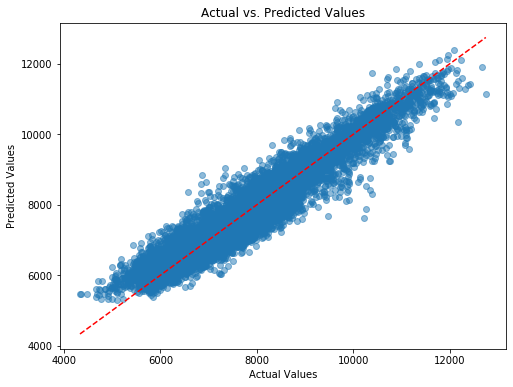

In [66]:
# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

plt.show()

In [67]:
# target_column = 'DIFF'
# keys = list(df.keys())
# feature_columns = [x for x in keys if x != target_column]

# not_norm_column = ['HourOfDay', 'DayOfWeek', 'DayOfYear', 'TOTALDEMAND']
# keys = list(df.keys())
# norm_columns = [x for x in keys if x not in not_norm_column]

# # feature_columns = ['HourOfDay', 'DayOfWeek', 'DayOfYear', 'TEMPERATURE_lagged','CPI_lagged']
# df = df.dropna()
# # Set the date threshold for training data (end of November 2020)
# training_end_date = '2020-11-30'

# train_data = df.loc[df.index <= training_end_date].copy()
# test_data = df.loc[df.index > training_end_date].copy()

# # Create a StandardScaler instance and normalize the data
# scaler = StandardScaler()
# train_data.loc[:, feature_columns] = scaler.fit_transform(train_data.loc[:, feature_columns])
# test_data.loc[:, feature_columns] = scaler.transform(test_data.loc[:, feature_columns])

# # Initialize variables to keep track of the best combination and R² value
# best_combination = []
# best_r2 = -float('inf')

# # Iterate through all possible feature combinations
# for r in range(1, len(feature_columns) + 1):
#     for combination in combinations(feature_columns, r):
#         # Convert the combination to a list
#         feature_subset = list(combination)

#         # Define training and testing features and target for the subset
#         X_train_subset = train_data.loc[:, feature_subset]
#         y_train_subset = train_data.loc[:, target_column]
#         X_test_subset = test_data.loc[:, feature_subset]
#         y_test_subset = test_data.loc[:, target_column]

#         # Create an XGBoost Regressor model
#         xgb_model = XGBRegressor(n_estimators=75, random_state=42)

#         # Fit the model on the training data
#         xgb_model.fit(X_train_subset, y_train_subset)

#         # Make predictions on the test data
#         y_pred = xgb_model.predict(X_test_subset)

#         # Calculate R² value for this combination
#         r2 = r2_score(y_test_subset, y_pred)

#         # Update the best combination and R² value if necessary
#         if r2 > best_r2:
#             best_combination = feature_subset
#             best_r2 = r2

# # Print the best feature combination and its R² value
# print(f"Best Feature Combination: {best_combination}")
# print(f"Best R-squared (R²) Value: {best_r2}")

In [68]:
# # Create a scatter plot
# plt.figure(figsize=(8, 6))
# plt.scatter(y_test, y_pred, alpha=0.5)
# plt.xlabel("Actual Values")
# plt.ylabel("Predicted Values")
# plt.title("Actual vs. Predicted Values")

# # Add a diagonal line for reference (perfect predictions)
# plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

# plt.show()